In [5]:
# Instalar dependencias necesarias
!sudo apt update
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!pip install pytesseract Pillow kagglehub

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,517 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,226 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,448 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-

In [6]:
!pip install opencv-python pillow
!pip install easyocr
import easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 17.4 MB/s eta 0:00:00


In [7]:
from IPython.display import Image, display
import torch
import cv2
import pytesseract
from PIL import Image as PILImage, ImageDraw
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


In [8]:
# Cargar el modelo entrenado
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/ColabArchivos/OCR_entrenamiento/exp/weights/best.pt')


/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2024-12-24 Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [28]:
import cv2
import numpy as np
from PIL import Image as PILImage

def transformar_perspectiva(img_path, model, num_boxes=6):
    # Realizar la predicción
    results = model(img_path)

    # Obtener los cuadros delimitadores (bounding boxes)
    boxes = results.xyxy[0]  # Formato xyxy

    # Ordenar los cuadros por área (en orden descendente)
    boxes = sorted(boxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)

    # Tomar los 'num_boxes' cuadros más grandes
    largest_boxes = boxes[:num_boxes]

    # Calcular el centro de cada cuadro
    centros = [(box[0] + box[2]) / 2 for box in largest_boxes]

    # Ordenar los cuadros por la coordenada 'y' de sus centros
    largest_boxes = sorted(largest_boxes, key=lambda x: (x[1] + x[3]) / 2)

    # Seleccionar los 6 cuadros cuyos centros estén más cercanos entre sí en el eje y
    def distancia_horizontal_promedio(boxes):
        if len(boxes) < 2:
            return float('inf')
        distancias = [abs((boxes[i + 1][1] + boxes[i + 1][3]) / 2 - (boxes[i][1] + boxes[i][3]) / 2) for i in range(len(boxes) - 1)]
        return np.mean(distancias)

    best_alignment = None
    min_distancia_horizontal = float('inf')

    for i in range(len(largest_boxes) - num_boxes + 1):
        current_boxes = largest_boxes[i:i + num_boxes]
        distancia = distancia_horizontal_promedio(current_boxes)
        if distancia < min_distancia_horizontal:
            min_distancia_horizontal = distancia
            best_alignment = current_boxes

    if best_alignment is None:
        best_alignment = largest_boxes[:num_boxes]

    # Extraer los puntos necesarios para la transformación de perspectiva
    leftmost_box = min(best_alignment, key=lambda x: x[0])
    rightmost_box = max(best_alignment, key=lambda x: x[2])

    x1, y1 = int(leftmost_box[0]), int(leftmost_box[1])
    x3, y3 = int(leftmost_box[0]), int(leftmost_box[3])
    x2, y2 = int(rightmost_box[2]), int(rightmost_box[1])
    x4, y4 = int(rightmost_box[2]), int(rightmost_box[3])

    height = abs(y3 - y1)
    width = abs(x2 - x1)
    new_height = int(width / 3)

    img = cv2.imread(img_path)
    src_points = np.array([[x1, y1], [x2, y2], [x4, y4], [x3, y3]], dtype='float32')
    dst_points = np.array([[0, 0], [width, 0], [width, new_height], [0, new_height]], dtype='float32')

    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_img = cv2.warpPerspective(img, matrix, (width, new_height))
    final_img = cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)

    cv2.imwrite('warped_img_metodo1.jpg', final_img)
    final_img_path = '/content/warped_img_metodo1.jpg'

    return final_img_path



In [9]:
def recortar_placa_por_umbral(img_path):
    # Leer la imagen
    img = cv2.imread(img_path)

    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Aplicar umbralización
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Encontrar contornos en la imagen umbralizada
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Encontrar el contorno más grande, que presumiblemente será la placa
    contorno_mas_grande = max(contours, key=cv2.contourArea)

    # Obtener el cuadro delimitador (bounding box) del contorno más grande
    x, y, w, h = cv2.boundingRect(contorno_mas_grande)

    # Recortar la imagen
    placa_recortada = img[y:y+h, x:x+w]

    # Guardar la imagen recortada (opcional)
    cv2.imwrite('placa_recortada_umbral.jpg', placa_recortada)

    return 'placa_recortada_umbral.jpg'

def mejorar_imagen_para_ocr(imagen_path1, umbral, border_size=10):
    # Leer la imagen
    imagen = cv2.imread(imagen_path1)

    # Convertir a escala de grises
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    # Aplicar umbral para mejorar el contraste
    _, thresh = cv2.threshold(gray, umbral, 255, cv2.THRESH_BINARY)

    # Opcional: Reducir el ruido
    thresh = cv2.medianBlur(thresh, 3)

    # Añadir un marco blanco alrededor de la imagen
    imagen_con_marco = cv2.copyMakeBorder(thresh, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    cv2.imwrite('imagen_con_marco.jpg', imagen_con_marco)
    imagen_con_marco = 'imagen_con_marco.jpg'
    return imagen_con_marco


def rotar_y_ajustar(img, y1, y2, x1, x2):
    # Calcular el ángulo de rotación necesario
    delta_y = y2 - y1
    delta_x = x2 - x1
    angle = np.arctan2(delta_y, delta_x) * 180 / np.pi

    # Obtener el centro de la imagen
    center = (img.shape[1] // 2, img.shape[0] // 2)

    # Calcular la matriz de rotación
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Aplicar la rotación
    rotated_img = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))
    return rotated_img

def rotacion_imagen_original(img_path, model, num_boxes=6):
    # Realizar la predicción
    results = model(img_path)

    # Obtener los cuadros delimitadores (bounding boxes)
    boxes = results.xyxy[0]  # Formato xyxy

    # Ordenar los cuadros por área (en orden descendente)
    boxes = sorted(boxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)

    # Tomar los 'num_boxes' cuadros más grandes
    largest_boxes = boxes[:num_boxes]

    # Encontrar los cuadros más a la izquierda y más a la derecha
    leftmost_box = min(largest_boxes, key=lambda x: x[0])
    rightmost_box = max(largest_boxes, key=lambda x: x[2])

    # Extraer los puntos necesarios
    x1, y1 = int(leftmost_box[0]), int(leftmost_box[1])  # Superior izquierdo del cuadro más a la izquierda
    x2, y2 = int(rightmost_box[2]), int(rightmost_box[1])  # Superior derecho del cuadro más a la derecha

    # Cargar la imagen original
    img = cv2.imread(img_path)

    # Rotar la imagen para alinear y1 y y2 en el mismo eje horizontal
    img_rotada = rotar_y_ajustar(img, y1, y2, x1, x2)

    # Guardar la imagen mejorada (opcional)
    cv2.imwrite('warped_img_mejorada.jpg', img_rotada)
    warped_img_mejorada_path = '/content/warped_img_mejorada.jpg'

    # Retornar la ruta de la imagen mejorada
    return warped_img_mejorada_path

img_path = '/content/drive/MyDrive/ColabArchivos/PlacasIphone/7.jpg'
# Uso del método

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


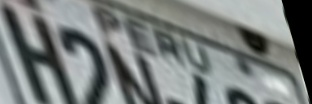

In [10]:
img_path = '/content/drive/MyDrive/ColabArchivos/Pruebas/7.jpg'
imagen = transformar_perspectiva(recortar_placa_por_umbral(rotacion_imagen_original(img_path,model)),model)
display(Image(imagen))

In [11]:
# Inicializar el lector de EasyOCR (seleccionar idioma)
reader = easyocr.Reader(['en'])  # 'en' es para inglés

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


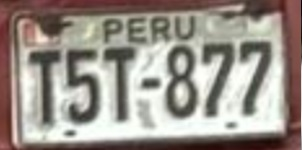

Texto detectado sin procesamiento: PeRU
Texto detectado sin procesamiento: lu51872


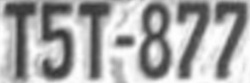

Texto detectado con procesamiento: T5T-877


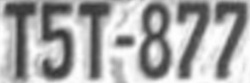

Texto detectado con tesseract 151-877



In [39]:
# Añadir un marco blanco alrededor de la
img_path = '/content/drive/MyDrive/ColabArchivos/PlacasIphone/7.jpg'
img_path = '/content/drive/MyDrive/ColabArchivos/Pruebas/2.jpg'
imagen_obtenida = transformar_perspectiva(recortar_placa_por_umbral(rotacion_imagen_original(img_path,model)),model)
#imagen_obtenida = transformar_perspectiva(img_path,model)

imagenConMarco = mejorar_imagen_para_ocr(imagen_obtenida,umbral = 120)


# Realizar OCR en la imagen
result = reader.readtext(imagen_obtenida)
result1 = reader.readtext(img_path)
result2 = reader.readtext('imagen_con_marco.jpg')




# Mostrar resultados
display(Image(img_path))
for detection in result1:
    text = detection[1]
    print("Texto detectado sin procesamiento:", text)


display(Image(imagen_obtenida))
for detection in result:
    text = detection[1]
    print("Texto detectado con procesamiento:", text)

#display(Image(imagenConMarco))
#for detection in result2:
#    text = detection[1]
#    print("Texto detectado con procesamiento rotado, thresh y marco:", text)

# Configuración de Tesseract (ajustar `--psm` según sea necesario)
custom_config = r'--psm 11'  # psm 8 = tratar como una sola línea de texto

# Extraer el texto utilizando pytesseract
texto_placa = pytesseract.image_to_string(imagen_obtenida, config=custom_config)
display(Image(imagen_obtenida))
# Mostrar el texto extraído
print("Texto detectado con tesseract", texto_placa)


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


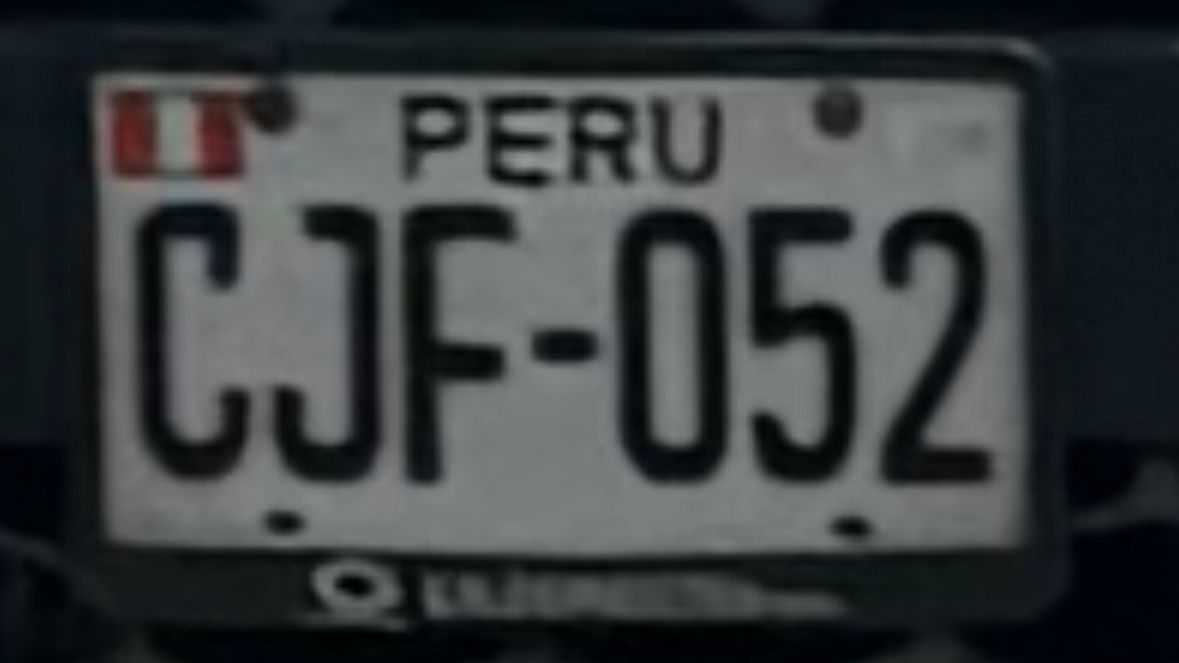

Texto detectado sin procesamiento: PERU
Texto detectado sin procesamiento: CJF-052
Texto detectado sin procesamiento: On


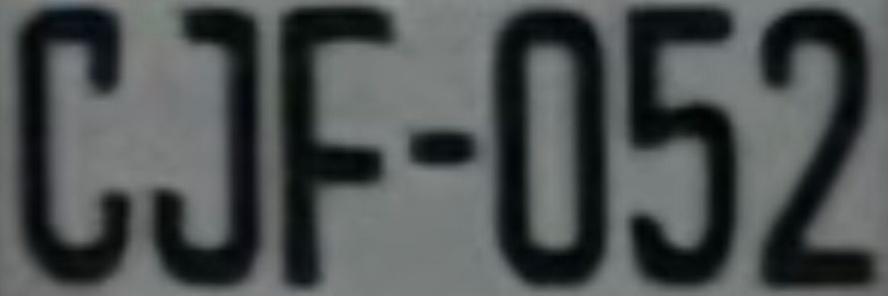

Texto detectado con procesamiento: CJF-052


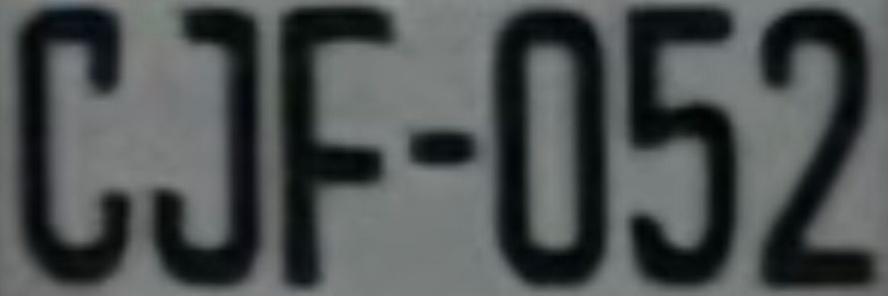

Texto detectado con tesseract CJF-052



In [ ]:
#img_path = '/content/drive/MyDrive/ColabArchivos/PlacasIphone/7.jpg'
img_path = '/content/drive/MyDrive/ColabArchivos/placa_recortada33.jpg'
#imagen_obtenida = transformar_perspectiva(recortar_placa_por_umbral(rotacion_imagen_original(img_path,model)),model)
imagen_obtenida = transformar_perspectiva(img_path,model)


imagenConMarco = mejorar_imagen_para_ocr(imagen_obtenida,umbral = 120)


result1 = reader.readtext(img_path)
result2 = reader.readtext(imagen_obtenida)
result3 = reader.readtext(imagenConMarco)


# Mostrar resultados
display(Image(img_path))
for detection in result1:
    text = detection[1]
    print("Texto detectado sin procesamiento:", text)


display(Image(imagen_obtenida))
for detection in result2:
    text = detection[1]
    print("Texto detectado con procesamiento:", text)


#display(Image(imagenConMarco))
#for detection in result3:
#    text = detection[1]
#    print("Texto detectado con procesamiento rotado, thresh y marco:", text)

# Configuración de Tesseract (ajustar `--psm` según sea necesario)
custom_config = r'--psm 8'  # psm 8 = tratar como una sola línea de texto

# Extraer el texto utilizando pytesseract
texto_placa = pytesseract.image_to_string(imagen_obtenida, config=custom_config)
display(Image(imagen_obtenida))
# Mostrar el texto extraído
print("Texto detectado con tesseract", texto_placa)
